In [17]:
import tensorboard
import tensorflow as tf
import keras 
import tensorflow_hub as hub
import tensorflow_text
import pandas as pd

In [18]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt
import numpy as np

In [19]:
#The dataset is Standford Sentiment Treebank (SST-2) dataset
# https://nlp.stanford.edu/sentiment/index.html
# 
# The dataset contains sentences from movie reviews and human annotations of their sentiment.
# 
# The task is to predict the sentiment of a given sentence.
# 
# The sentences are annotated on a scale of five values: very negative, negative, neutral, positive, very positive.

dictionary = pd.read_csv('Data/stanfordSentimentTreebank/dictionary.txt', sep='|')
#sentiment_labels is a txt file with the sentiment labels
sentiment_labels = pd.read_csv('Data/stanfordSentimentTreebank/sentiment_labels.txt', sep='|')

In [20]:
#merge the dictionary and sentiment_labels
datasetMindsetEval = dictionary.merge(sentiment_labels, on='phrase_index')
#convert into a dataframe
datasetMindsetEval = pd.DataFrame(datasetMindsetEval)

In [21]:
#if sentiment socre is larger than 0.6, then the sentiment is positive
#if sentiment socre is smaller than 0.4, then the sentiment is negative
#if sentiment socre is between 0.4 and 0.6, then the sentiment is neutral
datasetMindsetEval['label'] = datasetMindsetEval['sentiment values'].apply(lambda x: 'positive' if x > 0.6 else ('negative' if x < 0.4 else 'neutral'))

In [22]:
data = datasetMindsetEval

In [23]:
from sklearn.preprocessing import LabelBinarizer
encoderNew = LabelBinarizer()
transfomed_label = encoderNew.fit_transform(data['label'])
data['label'] = transfomed_label

# Save the encoder classes for later use
np.save('./Models/encoder.npy', encoderNew.classes_)

In [24]:
# data preprocessing
data['sentence'] = data['sentence'].apply(lambda x: x.lower())
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\n', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\t', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\r', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\xa0', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\u200b', ' '))
data['sentence'] = data['sentence'].apply(lambda x: x.replace('\ufeff', ' '))

stop_words = ['a', 'about', 'above', 'after', 'again', 'against', 'all', 'am', 'an', 'and', 'any', 'are',  'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'could',  'did', 'do', 'does', 'doing', 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadnt', 'has', 'have', 'havent', 'having', 'he', 'hed', 'hell', 'hes', 'her', 'here', 'heres', 'hers', 'herself', 'him', 'himself', 'his', 'how', 'hows', 'i', 'id', 'ill', 'im', 'ive', 'if', 'in', 'into', 'is', 'isnt', 'it', 'its', 'its', 'itself', 'lets', 'me', 'more', 'most', 'mustnt', 'my', 'myself', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'ought', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 'same', 'she', 'shed', 'shell', 'shes', 'should', 'so', 'some', 'such', 'than', 'that', 'thats', 'the', 'their', 'theirs', 'them', 'themselves', 'then', 'there', 'theres', 'these', 'they', 'theyd', 'theyll', 'theyre', 'theyve', 'this', 'those', 'through', 'to', 'too', 'under', 'until', 'up', 'very', 'was', 'we', 'wed', 'well', 'were', 'weve', 'were', 'what', 'whats', 'when', 'whens', 'where', 'wheres', 
        'which', 'while', 'who', 'whos', 'whom', 'why', 'whys', 'with', 'would', 'you', 'youd', 'youll', 'youre', 'youve', 'your', 'yours', 'yourself', 'yourselves']
#removing stop words
data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

#remove punchations
import string
punctuations = string.punctuation
data['sentence'] = data['sentence'].apply(lambda x: ' '.join([word for word in x.split() if word not in (punctuations)]))

In [25]:
#split the dataset into train, validation and test
train_dataset = datasetMindsetEval.sample(frac=0.8, random_state=0)
test_dataset = datasetMindsetEval.drop(train_dataset.index)
validation_dataset = test_dataset.sample(frac=0.5, random_state=0)
test_dataset = test_dataset.drop(validation_dataset.index)

In [26]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dataset['sentence'], train_dataset['label']))

In [27]:
val_ds = tf.data.Dataset.from_tensor_slices((validation_dataset['sentence'], validation_dataset['label']))

In [28]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
seed = 43

train_ds = train_ds.shuffle(buffer_size=len(data)).batch(batch_size)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = val_ds.shuffle(buffer_size=len(val_ds)).batch(batch_size)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [29]:
tfhub_encoder = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
tfhub_prepocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"


In [30]:
from tensorflow.keras.optimizers import Adam

In [31]:
# create the deep learning model to classify text into three categories
text_input = keras.Input(shape=(), dtype='string', name='text_input')
preprocessing_layer = hub.KerasLayer(tfhub_prepocess, name='Preprocessing_for_BERT')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(tfhub_encoder, trainable=False, name='BERT_encoder')
outputs = encoder(encoder_inputs)
x = keras.layers.Dropout(0.2)(outputs['sequence_output'])
x = keras.layers.Dense(64, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(32, activation='relu')(x)
x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.Dense(20, activation='relu')(x)
#x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(3, activation='softmax')(x)
model = keras.Model(inputs=[text_input], outputs=x)
model.compile(optimizer=Adam(lr=0.0001),
                loss='sparse_categorical_crossentropy',             
                metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text_input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 Preprocessing_for_BERT (KerasL  {'input_mask': (Non  0          ['text_input[0][0]']             
 ayer)                          e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

c:\Users\USER\anaconda3\envs\research\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [32]:
from tensorflow.keras.callbacks import TensorBoard
import time

# logs about the training process
# accuracy and loss are plotted in the TensorBoard
log_dir = "logs/fit/" + str(int(time.time()))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [33]:
epochs = 50
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    verbose=1,
                    callbacks=[
                        keras.callbacks.TensorBoard("logs/fit/" + str(int(time.time())),
                                                    histogram_freq=1,
                                                    write_graph=True,
                                                    write_images=True),
                        keras.callbacks.EarlyStopping(patience=5,
                                                      monitor='val_loss')

                    ])


Epoch 1/50
11962/11962 [==============================] - 2419s 201ms/step - loss: 0.3940 - accuracy: 0.8177 - val_loss: 0.3877 - val_accuracy: 0.8185
Epoch 2/50
11962/11962 [==============================] - 2374s 198ms/step - loss: 0.3660 - accuracy: 0.8324 - val_loss: 0.3817 - val_accuracy: 0.8218
Epoch 3/50
11962/11962 [==============================] - 2366s 198ms/step - loss: 0.3534 - accuracy: 0.8395 - val_loss: 0.3765 - val_accuracy: 0.8262
Epoch 4/50
11962/11962 [==============================] - 2368s 198ms/step - loss: 0.3424 - accuracy: 0.8458 - val_loss: 0.3761 - val_accuracy: 0.8267
Epoch 5/50
11962/11962 [==============================] - 2370s 198ms/step - loss: 0.3323 - accuracy: 0.8513 - val_loss: 0.3772 - val_accuracy: 0.8269
Epoch 6/50
11962/11962 [==============================] - 2368s 198ms/step - loss: 0.3238 - accuracy: 0.8556 - val_loss: 0.3786 - val_accuracy: 0.8257
Epoch 7/50
11962/11962 [==============================] - 2366s 198ms/step - loss: 0.3162 - ac

In [34]:
test_ds = tf.data.Dataset.from_tensor_slices((test_dataset['sentence'], test_dataset['label']))

In [35]:
# create the test dataset
test_ds = test_ds.shuffle(buffer_size=len(test_ds)).batch(batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


# evaluate the model
results = model.evaluate(test_ds, verbose=1, callbacks=[
    keras.callbacks.TensorBoard(log_dir='./logs',
                                histogram_freq=1,
                                write_graph=True,
                                write_images=True)]
)


# print the results
print('Test loss:', results[0])
print('Test accuracy:', results[1])

1496/1496 [==============================] - 257s 172ms/step - loss: 0.3798 - accuracy: 0.8305
Test loss: 0.379769891500473
Test accuracy: 0.8305396437644958


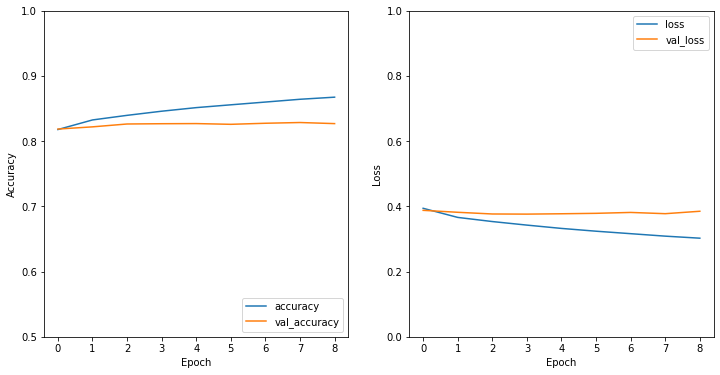

In [36]:
#draw the accuracy and loss curves
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim([0, 1])
plt.show()



In [37]:
# Test Model with Sample Test Data
text = 'There were members who do not contribute for the projects. Actually I do not prefer to work with a team'


# get prdiction from the model
prediction = model.predict([text])

In [38]:
encoderNew.inverse_transform(prediction)

array(['neutral'], dtype='<U8')

In [39]:
#model name with date and time
model_name = 'model_' + str(int(time.time()))

# save the model
model.save(model_name + '.h5')

In [40]:
#save the model
model.save('./Models/' + model_name)

INFO:tensorflow:Assets written to: ./Models/model_1665359793\assets


INFO:tensorflow:Assets written to: ./Models/model_1665359793\assets


In [41]:
# load the model
model = keras.models.load_model('./Models/' + model_name)

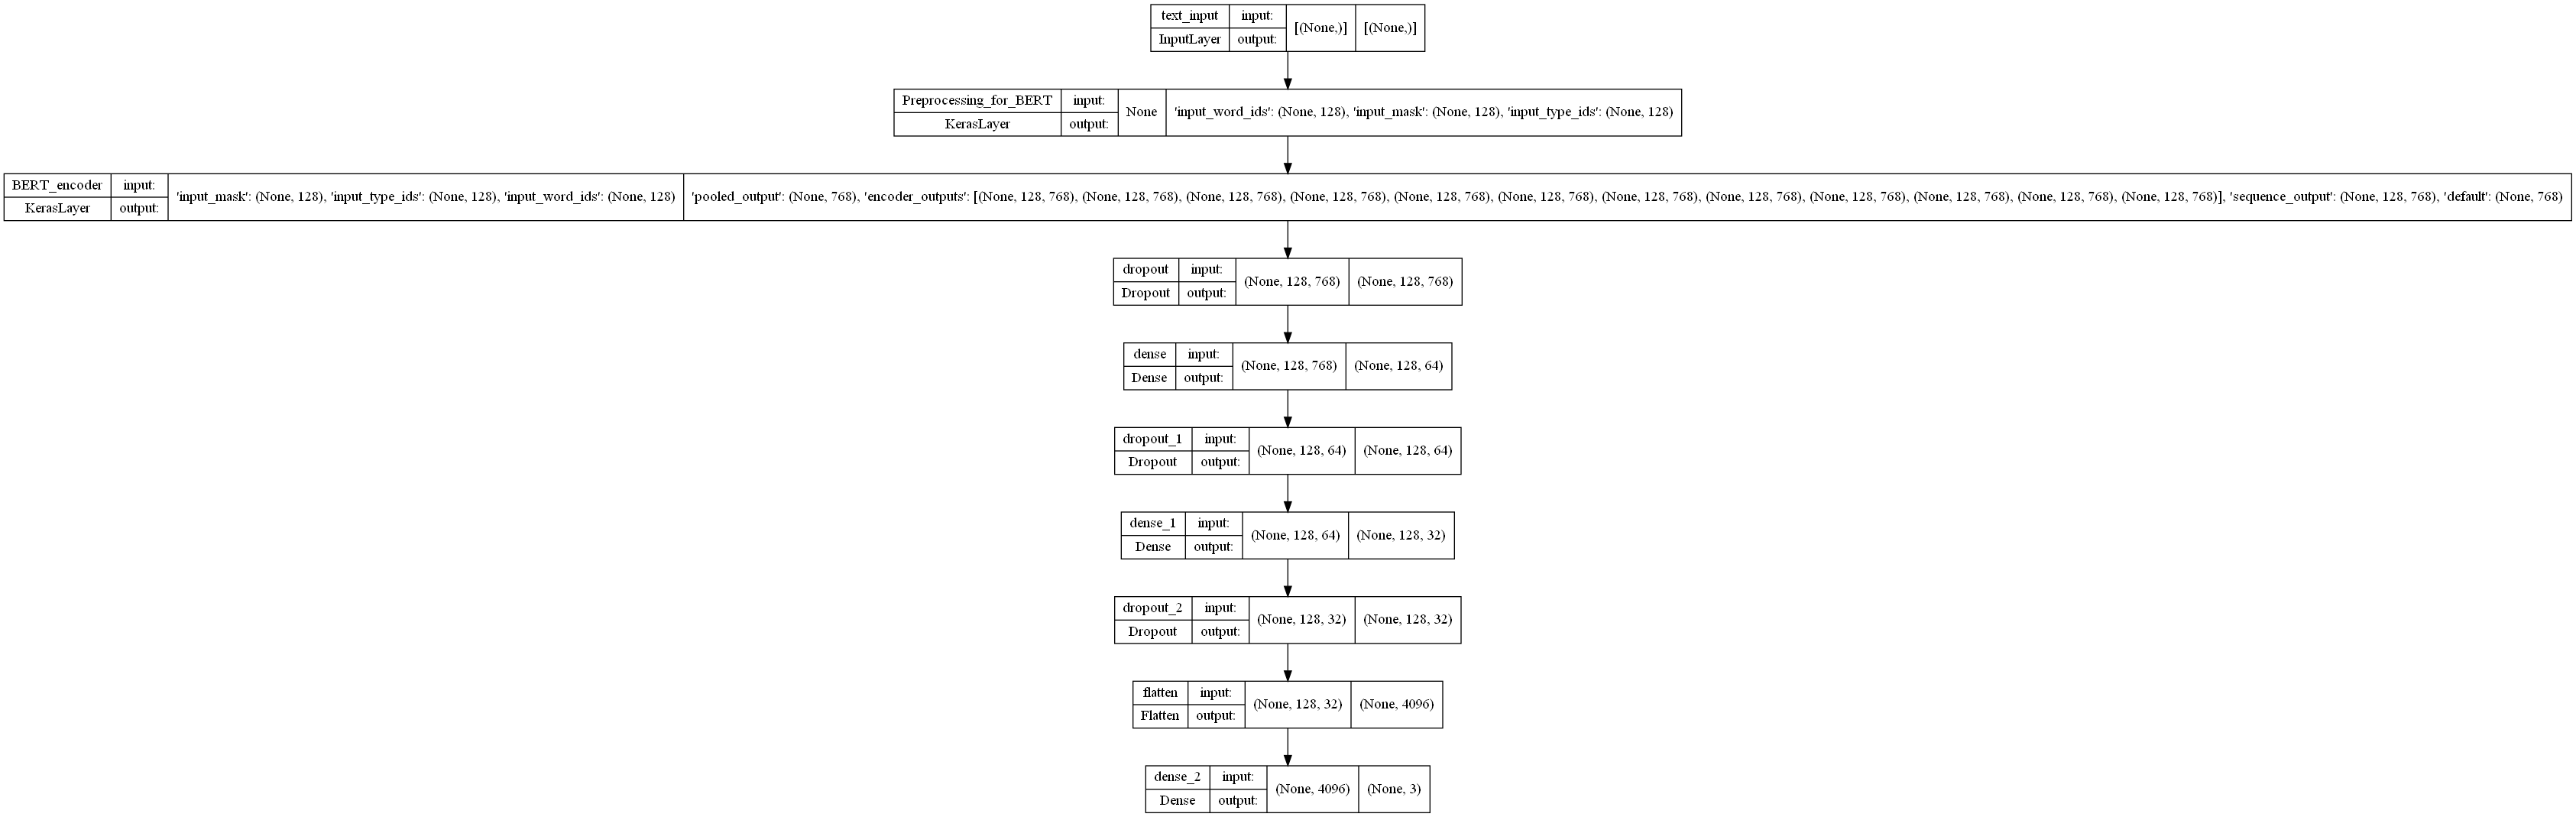

In [42]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='./Model Output/' + model_name + '.png', show_shapes=True, show_layer_names=True)

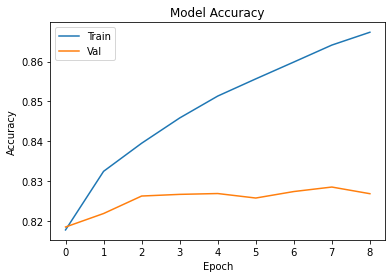

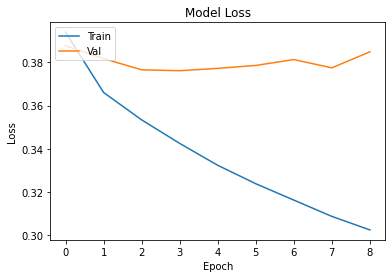

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()